In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from datetime import datetime
import time
import os
import warnings
from siml.detect_peaks import *
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")

input_folder = r'C:\Users\A4023862\OneDrive - Astellas Pharma Inc\SGA\inputs'
output_folder =  r'C:\Users\A4023862\OneDrive - Astellas Pharma Inc\SGA\outputs'

######################
# READ IN DATA
######################
input_file = 'sku_units_emea_v2.xlsx'
path = os.path.join(input_folder, input_file)
sku=pd.read_excel(path, engine='openpyxl')

input_file = 'SGA Xospata US JP CN EU5.xlsx'
path = os.path.join(input_folder, input_file)
sga=pd.read_excel(path, engine='openpyxl', skiprows = 15)

In [40]:
# Find columns with all null
columns = sga.columns
columns2remove = sga.columns[sga.isna().all()].tolist()

# Filter out
print(sga.shape)
result = [x for x in columns if x not in columns2remove]
sga2=sga[result]
print(sga2.shape)

col_names = ['region',
 'product',
 'ds',
 'sales',
 'units',
 'Promotion Expenses',
 'Advertising Expenses',
 'Distribution',
 'Co-Promotion',
 'Sample cost',
 'Congresses',
 'Speaker Programs',
 'Advisory Board',
 'Market Research/Information Sourcing',
 'Market access',
 'Medical Publications',
 'R&D Clinical Trial Material & CMC',
 'Research Materials & Supplies',
 'Patient/Investigator Fees',
 'Product Registration Fees',
 'Social Contribution Activity (SCA)',
 'Donations/Grants',
 'Professional Fee',
 'Advisory Services',
 'Outsourced Services',
 'Event',
 'Training (Field Based/Product Related)',
 'IT & Communications',
 'Buildings & Facilities',
 'Levied SGA Tax and like',
 'Doubtful Debts',
 'Non Payroll Other']

# Fix column names
col_names = [x.replace(' ','_') for x in col_names]
col_names = [x.replace('&','') for x in col_names]
col_names = [x.replace('/','') for x in col_names]
col_names = [x.replace('-','') for x in col_names]
col_names = [x.replace('(','') for x in col_names]
col_names = [x.replace(')','') for x in col_names]
col_names = [x.lower() for x in col_names]

sga2.columns = col_names

# Delete 1st row
sga2 = sga2.drop(index=0).reset_index(drop=True)

(481, 41)
(481, 32)


In [41]:
# Extract substring of ds to parse into date
for i in range(0,len(sga2['ds'])):
    sga2['ds'][i]=sga2['ds'][i].split('- FY',1)[1]

# Convert to date
sga2['ds'] =  pd.to_datetime(sga2['ds'], format='%y %B')
sga2['year'], sga2['month'], sga2['day'] = sga2['ds'].dt.year, sga2['ds'].dt.month, sga2['ds'].dt.day

# Address fiscal year dates
for i in range(0,len(sga2['ds'])):
    if sga2['month'][i] <4:
        sga2['year'][i]=sga2['year'][i]+1

# Create new date
sga2['ds']=pd.to_datetime(sga2[['year', 'month', 'day']])

# Save new sales data
output_file = 'sga2.csv'
path = os.path.join(output_folder, output_file)
sga2.to_csv(path)

In [104]:
def construct_fft(yvalues, deg_polyfit=1, real_abs_only=True):
    N = len(yvalues)
    xvalues = np.arange(N)
    
    # we calculate the trendline and detrended signal with polyfit
    z2 = np.polyfit(xvalues, yvalues, deg_polyfit)
    p2 = np.poly1d(z2)
    yvalues_trend = p2(xvalues)
    yvalues_detrended = yvalues - yvalues_trend
    
    # The fourier transform and the corresponding frequencies
    fft_y = np.fft.fft(yvalues_detrended)
    fft_x = np.fft.fftfreq(N)
    if real_abs_only:
        fft_x = fft_x[:len(fft_x)//2]
        fft_y = np.abs(fft_y[:len(fft_y)//2])
    return fft_x, fft_y, p2

def get_integer_no_of_periods(yvalues, fft_x, fft_y, frac=1.0, mph=0.4):
    N = len(yvalues)
    fft_y_real = np.abs(fft_y[:len(fft_y)//2])
    fft_x_real = fft_x[:len(fft_x)//2]
    
    mph = np.nanmax(fft_y_real)*mph
    indices_peaks = detect_peaks(fft_y_real, mph=mph)
    peak_fft_x = fft_x_real[indices_peaks]
    main_peak_x = peak_fft_x[0]
    T = int(1/main_peak_x)
    
    no_integer_periods_all = N//T
    no_integer_periods_frac = int(frac*no_integer_periods_all)
    no_samples = T*no_integer_periods_frac
    
    yvalues_ = yvalues[-no_samples:]
    xvalues_ = np.arange(len(yvalues))
    return xvalues_, yvalues_

def restore_signal_from_fft(fft_x, fft_y, N, extrapolate_with, frac_harmonics):
    xvalues_full = np.arange(0, N + extrapolate_with)
    restored_sig = np.zeros(N + extrapolate_with)
    indices = list(range(N))
    
    # The number of harmonics we want to include in the reconstruction
    indices.sort(key = lambda i: np.absolute(fft_x[i]))
    max_no_harmonics = len(fft_y)
    no_harmonics = int(frac_harmonics*max_no_harmonics)
    
    for i in indices[:1 + no_harmonics * 2]:
        ampli = np.absolute(fft_y[i]) / N
        phase = np.angle(fft_y[i])
        restored_sig += ampli * np.cos(2 * np.pi * fft_x[i] * xvalues_full + phase)
    # return the restored signal plus the previously calculated trend
    return restored_sig

def reconstruct_from_fft(yvalues, 
                         frac_harmonics=1.0, 
                         deg_polyfit=2, 
                         extrapolate_with=0, 
                         fraction_signal = 1.0,
                         mph = 0.4):
    N_original = len(yvalues)
    fft_x, fft_y, p2 = construct_fft(yvalues, deg_polyfit, real_abs_only=False)
    xvalues, yvalues = get_integer_no_of_periods(yvalues, fft_x, fft_y, frac=fraction_signal, mph=mph)
    fft_x, fft_y, p2 = construct_fft(yvalues, deg_polyfit, real_abs_only=False)
    N = len(yvalues)

    xvalues_full = np.arange(0, N + extrapolate_with)
    restored_sig = restore_signal_from_fft(fft_x, fft_y, N, extrapolate_with, frac_harmonics)
    restored_sig = restored_sig + p2(xvalues_full)
    return restored_sig[-extrapolate_with:]

56840.45997954632
56750.242817572806
62169.44174630823
74156.40350715317


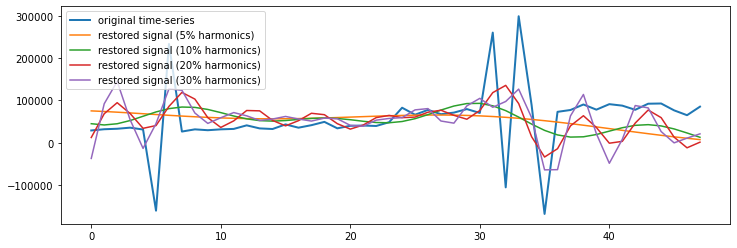

In [105]:
# PARAMS
region='D_US - US'
product='P_XTD_TOT - Xtandi Total'
hdt_period=12

# FILTER DATA
sga2 = sga[(sga['region']==region) & (sga['product']==product)]
yvalues = sga2['units'].values
xvalues = np.arange(len(yvalues))

# ANALYZE
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(yvalues, linewidth=2, label='original time-series')

list_frac_harmonics = [0.05, 0.1, 0.2, 0.3]

for ii, frac_harmonic in enumerate(list_frac_harmonics):
    yvalues_restored = reconstruct_from_fft(yvalues[:(len(yvalues)-hdt_period)], frac_harmonics=frac_harmonic, extrapolate_with=len(yvalues))
    label = 'restored signal ({:.0f}% harmonics)'.format(100*frac_harmonic)
    rms = mean_squared_error(yvalues[-hdt_period:], yvalues_restored[-hdt_period:], squared=False)
    print(rms)
    ax.plot(yvalues_restored, label=label)
ax.legend(loc='upper left')
plt.show()